## Assignment - Recommendation System

#### <a id='3'>Problem Statement:- As a sales manager for "BeerMart", an online beer store in the United States.I have to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. Once the data is collected. I need to complete the following tasks.

1. Data preparation
2. Data exploration
3. Recommendation Models.</a> 

### <a id='3'>Setting Up the Environment</a>

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# import libraties
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import MinMaxScaler
from numpy import *

In [2]:
#loading the "beer_data" CSV file
beerdata_original= pd.read_csv('beer_data.csv')

In [3]:
#Top 5 rows of the dataframe
beerdata_original.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [4]:
beerdata_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_beerid         475984 non-null  int64  
 1   review_profilename  475884 non-null  object 
 2   review_overall      475984 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB


In [5]:
#checking % of missing values
beerdata_original.isnull().sum() * 100 / len(beerdata_original)

beer_beerid           0.000000
review_profilename    0.021009
review_overall        0.000000
dtype: float64

In [6]:
#drop null values from DataFrame
beerdata_original = beerdata_original.dropna() 
beerdata_original.isnull().sum() * 100 / len(beerdata_original)

beer_beerid           0.0
review_profilename    0.0
review_overall        0.0
dtype: float64

In [7]:
beerdata_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475884 entries, 0 to 475983
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_beerid         475884 non-null  int64  
 1   review_profilename  475884 non-null  object 
 2   review_overall      475884 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.5+ MB


In [8]:
#Checking duplicates
beerdata_original.duplicated(['beer_beerid','review_profilename']).sum()

1422

In [9]:
# dropping duplicates
beerdata_original = beerdata_original.drop_duplicates(['beer_beerid','review_profilename'],keep='first')
beerdata_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474462 entries, 0 to 475983
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_beerid         474462 non-null  int64  
 1   review_profilename  474462 non-null  object 
 2   review_overall      474462 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.5+ MB


In [10]:
beerdata_original.describe()

,beer_beerid,review_overall
count,474462.000000,474462.000000
mean,21674.478038,3.814274
std,21798.233764,0.720484
min,3.000000,0.000000
25%,1717.000000,3.500000
50%,13896.000000,4.000000
75%,39417.000000,4.500000
max,77317.000000,5.000000


In [11]:
beerdata_original.shape

(474462, 3)

### <a id='3'>Data Preparation</a>

1. Figuring out the value of N using EDA.

In [12]:
# Cheking review counts for beerid
beer_id_count = pd.DataFrame(beerdata_original.beer_beerid.value_counts(sort=True))

In [13]:
beer_id_count.shape

(40304, 1)

In [14]:
# Calculating highest ratings
beer_id_count.head()

,beer_beerid
2093,977
412,966
1904,902
1093,840
92,812


Beerid 2093 has maximum number of reviews.

In [15]:
# Calculating lowest ratings
beer_id_count.tail()

,beer_beerid
31461,1
53362,1
57460,1
42666,1
69794,1


Text(0.5, 0, 'Number of Reviews')

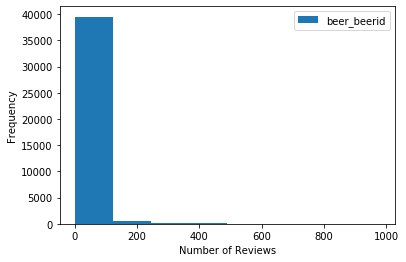

In [16]:
beer_id_count.plot.hist(bins=8)
plt.xlabel('Number of Reviews')

In [17]:
#Checking Beerid which have recieved low review
lowest_beerid = pd.DataFrame(beer_id_count[beer_id_count==1]).sum()
lowest_beerid

beer_beerid    18080.0
dtype: float64

In [18]:
#Checking Beerid which has review between 1-50 
beerid_counts_2 = pd.DataFrame(beer_id_count[beer_id_count<=50]).sum()
print(beerid_counts_2)

beer_beerid    180265.0
dtype: float64


##### Since 180265 beerid's which has rating below 50 we remove these , as they have low ratings.

In [19]:
#Checking Beerid which have rating above 50
beers = beerdata_original.groupby('beer_beerid')['review_overall'].count().reset_index()
print(beers.count())
beers = beers.sort_values('review_overall', ascending=False)

beercountabove50 = beers[beers.review_overall >= 50]


beer_beerid       40304
review_overall    40304
dtype: int64


In [20]:
# Removing the beer if the count is less than 50
beerdata_copy = beerdata_original[beerdata_original.groupby('beer_beerid')['beer_beerid'].transform('size') > 30]
beerdata_copy.head()

,beer_beerid,review_profilename,review_overall
12,436,Brent,3.0
18,25414,NJpadreFan,4.0
19,25414,vacax,2.5
20,25414,mikesgroove,4.0
21,25414,hdofu,4.0


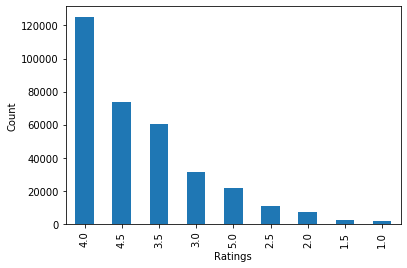

In [21]:
pd.value_counts(beerdata_copy['review_overall']).plot.bar()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

##### Most of the beer have 4.0 rating

In [22]:
# Average user rating
userrating_avg = pd.DataFrame(beerdata_copy.groupby('review_profilename')['review_overall'].mean())
userrating_avg = userrating_avg.reset_index()
userrating_avg['review_overall'] = round(userrating_avg['review_overall'],2)
userrating_avg.shape

(20182, 2)

### <a id='3'>Data Exploration</a>

In [23]:
userrating_avg.head()

,review_profilename,review_overall
0,0110x011,4.33
1,01Ryan10,5.00
2,04101Brewer,4.00
3,05Harley,4.14
4,0beerguy0,4.17


In [24]:
# cheching highest and lowest user rating
userrating_avg = userrating_avg.sort_values('review_overall')
print(userrating_avg.head())
print(userrating_avg.tail())

      review_profilename  review_overall
16057             myhair             1.0
11500             domjwl             1.0
13212            ifij775             1.0
13217           ifurlong             1.0
11903           elbowone             1.0
      review_profilename  review_overall
19121            timhoth             5.0
11140       davisdandrew             5.0
11144          dawgontap             5.0
7253           SurlyZach             5.0
20181           zzajjber             5.0


In [25]:
# Average rating beer
beerrating_avg = pd.DataFrame(beerdata_copy.groupby('beer_beerid')['review_overall'].mean())
beerrating_avg = beerrating_avg.reset_index()
beerrating_avg['review_overall'] = round(beerrating_avg['review_overall'],2)
beerrating_avg.shape

(3057, 2)

In [26]:
beerrating_avg.head()

,beer_beerid,review_overall
0,5,3.55
1,6,3.71
2,7,3.32
3,9,3.38
4,10,3.88


In [27]:
beerrating_avg = beerrating_avg.sort_values('review_overall')
print(beerrating_avg.head())
print(beerrating_avg.tail())

      beer_beerid  review_overall
781          2213            1.43
2185        37389            1.70
1636        20638            1.83
117           233            1.88
2231        38763            1.88
      beer_beerid  review_overall
1314         7971            4.60
1680        21690            4.61
595          1545            4.62
2359        41928            4.63
1541        16814            4.65


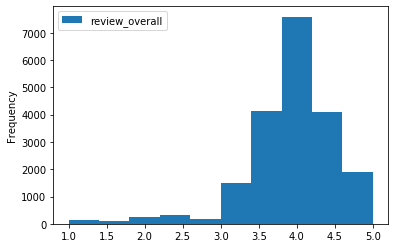

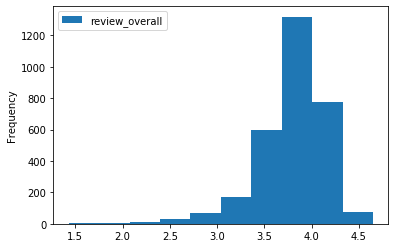

In [28]:
plt1= userrating_avg.plot(x='review_profilename', y='review_overall', kind = 'hist')
plt1

plt2 =beerrating_avg.plot(x='beer_beerid', y='review_overall', kind = 'hist')
plt2

#### From above plot we can see that
- Mostly users has given 4 rating
- Mostly Beer rating is 4.0

In [29]:
# total count or beer
beerdata_copy.head()

,beer_beerid,review_profilename,review_overall
12,436,Brent,3.0
18,25414,NJpadreFan,4.0
19,25414,vacax,2.5
20,25414,mikesgroove,4.0
21,25414,hdofu,4.0


### <a id='3'>Recommendation Model</a>

In [30]:
train, test = train_test_split(beerdata_copy, test_size=0.30, random_state=31)

In [31]:
df_beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [32]:
print(train.shape)
print(test.shape)

(234207, 3)
(100375, 3)


In [33]:
df_beer_features.head()


beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01Ryan10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04101Brewer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0beerguy0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Copy train and test dataset
These dataset will be used for prediction and evaluation.

1. Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. 
2. The beers not rated by user is marked as 1 for prediction. Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [34]:
dummy_train = train.copy()
dummy_test = test.copy()

In [35]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [36]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [37]:
dummy_train.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01Ryan10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
04101Brewer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0beerguy0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [38]:
dummy_test.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74530,74548,74579,74827,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0beerguy0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0runkp0s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
print(dummy_train.shape)
print(dummy_test.shape)

(17729, 3057)
(12834, 3057)


#### User Similarity Matrix
Using Cosine Similarity

In [ ]:
# User Similarity Matrix
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

In [ ]:
user_correlation.shape

#### User Adjusted Cosine

##### Here, not removing the NaN values and calculating the mean only for the movies rated by the user

In [ ]:
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [ ]:
beer_features.head()

#### Normalising the rating of the beers for each user around 0 mean¶


In [ ]:
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [ ]:
df_subtracted.head()

#### Finding cosine similarity¶


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

In [ ]:
# relation between top 10 users
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(user_correlation).iloc[:10,:10], annot = True)
plt.show()

#### Prediction¶
Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

In [ ]:
user_predicted_ratings = np.dot(user_correlation, beer_features.fillna(0))
user_predicted_ratings

In [ ]:
user_predicted_ratings.shape

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

### Finding the top 5 recommendation for the user 1

In [ ]:
user_final_rating.iloc[1].sort_values(ascending=False)[0:5]

In [ ]:
user_final_rating[:10]

### Item Based Similarity
#### Using Correlation
Taking the transpose of the rating matrix to normalize the rating around the mean for different beer ID. In the user based similarity, we had taken mean for each user intead of each beer.

In [ ]:
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_features.head()

In [ ]:
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [ ]:
df_subtracted.head()

Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value

In [ ]:
# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
rint(item_correlation)

In [ ]:
# relation between top 10 items
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(item_correlation).iloc[:10,:10], annot = True)
plt.show()

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

### Prediction

In [ ]:
item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_correlation)
item_predicted_ratings

In [ ]:
item_predicted_ratings.shape

In [ ]:
dummy_train.shape

Filtering the rating only for the beers not rated by the user for recommendation`

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

### Top 5 prediction for the user -1

In [ ]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:5]

### Evaluation
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the beer already rated by the user insead of predicting it for the beer not rated by the user.

### Using User Similarity


In [ ]:
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

In [ ]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

### Doing prediction for the beers rated by the user

In [ ]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [ ]:
test_user_final_rating.head()


### Evaluation

### Calculating the RMSE for only the beers rated by user. For RMSE, normalising the rating to (1,5) range.

In [ ]:
X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
X = X.fillna(X.mean())
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

### Using Item similarity

In [ ]:
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [ ]:
test_item_correlation.shape

In [ ]:
test_beer_features.shape

In [ ]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

In [ ]:
test_ = test.pivot(
   index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [ ]:
X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
X = X.fillna(X.mean())
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

- RMSE vlue is 0.97, which shows model has good fit
- RMSE value for item based collaborative model has is 0.104

### Using User based filtering model

#### Top 5 beers that I would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.(User based)

In [ ]:
# cokes

cokes = pd.DataFrame(user_final_rating[user_final_rating.index=='cokes']).T
cokes.sort_values(by='cokes',ascending=False)[0:5]

In [ ]:
# genog

genog = pd.DataFrame(user_final_rating[user_final_rating.index=='genog']).T
genog.sort_values(by='genog',ascending=False)[0:5]

In [ ]:
# giblet
giblet = pd.DataFrame(user_final_rating[user_final_rating.index=='giblet']).T
giblet.sort_values(by='giblet',ascending=False)[0:5]

#### Top 5 beers that I would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.(Item based)

In [ ]:
# cokes
cokes_item = pd.DataFrame(item_final_rating[user_final_rating.index=='cokes']).T
cokes_item.sort_values(by='cokes',ascending=False)[0:5]

In [ ]:
# geno
genog_item = pd.DataFrame(item_final_rating[user_final_rating.index=='genog']).T
genog_item.sort_values(by='genog',ascending=False)[0:5]

In [ ]:
# giblet
giblet_item = pd.DataFrame(item_final_rating[user_final_rating.index=='giblet']).T
giblet_item.sort_values(by='giblet',ascending=False)[0:5]